<a href="https://colab.research.google.com/github/MagicMoleMM/Machine_learning_LSTM/blob/main/LSTM_EURUSD_Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch



## Download Dataset

In [1]:
import requests
import csv
import seaborn as sns

## Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

Функция получения данных AV

In [3]:
def get_fx_daily(from_symbol, to_symbol, outputsize, apikey):

    url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={from_symbol}&to_symbol={to_symbol}&outputsize={outputsize}&datatype=csv&apikey={apikey}'

    r = requests.get(url)
    decoded_content = r.content.decode('utf-8')
    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    dt = pd.DataFrame(data)
    dt.columns = ['timestamp','open', 'high', 'low', 'close']
    dt = dt.iloc[1:]
    dt = dt.set_index('timestamp', inplace=False)

    return dt

Получение данных AV

In [4]:
from_symbol = 'USD'
to_symbol = 'RUB'
interval = '60min'  # 1min, 5min, 15min, 30min, 60min
outputsize = 'full'  # Optional compact or full
apikey = '2GGORTBXQIFSR2AF'

#  Загружаем данные


data_1d_load = get_fx_daily(from_symbol, to_symbol, outputsize, apikey).iloc[::-1]

Загрузка в формате csv


In [5]:
data_1d_load.to_csv(f'{from_symbol}{to_symbol}_1d.csv')

In [6]:
print(data_1d_load)

                open      high       low     close
timestamp                                         
2014-11-24  45.69910  45.84200  44.34780  44.94000
2014-11-25  44.94000  46.34500  44.59670  46.31390
2014-11-26  46.30000  47.42130  46.01750  47.39360
2014-11-27  47.39500  49.27400  46.68890  49.09690
2014-11-28  48.63850  50.68550  48.61600  50.47380
...              ...       ...       ...       ...
2022-07-14  58.46700  60.25000  57.77500  59.20500
2022-07-15  58.26680  59.70000  55.62500  55.75000
2022-07-18  55.50000  58.06700  55.50000  56.99160
2022-07-19  56.98460  57.20000  54.98500  56.49140
2022-07-20  56.45580  56.45580  54.25700  54.70000

[1998 rows x 4 columns]



DataFrame

In [7]:
training_set_1 = pd.DataFrame(data_1d_load)
training_set_1

,open,high,low,close
timestamp,,,,
2014-11-24,45.69910,45.84200,44.34780,44.94000
2014-11-25,44.94000,46.34500,44.59670,46.31390
2014-11-26,46.30000,47.42130,46.01750,47.39360
2014-11-27,47.39500,49.27400,46.68890,49.09690
2014-11-28,48.63850,50.68550,48.61600,50.47380
...,...,...,...,...
2022-07-14,58.46700,60.25000,57.77500,59.20500
2022-07-15,58.26680,59.70000,55.62500,55.75000
2022-07-18,55.50000,58.06700,55.50000,56.99160


 Цены закрытия

In [8]:
price_close = training_set_1.close
pd.to_datetime(price_close.index)
pd.to_numeric(price_close.values)
price_close

timestamp
2014-11-24    44.94000
2014-11-25    46.31390
2014-11-26    47.39360
2014-11-27    49.09690
2014-11-28    50.47380
                ...   
2022-07-14    59.20500
2022-07-15    55.75000
2022-07-18    56.99160
2022-07-19    56.49140
2022-07-20    54.70000
Name: close, Length: 1998, dtype: object

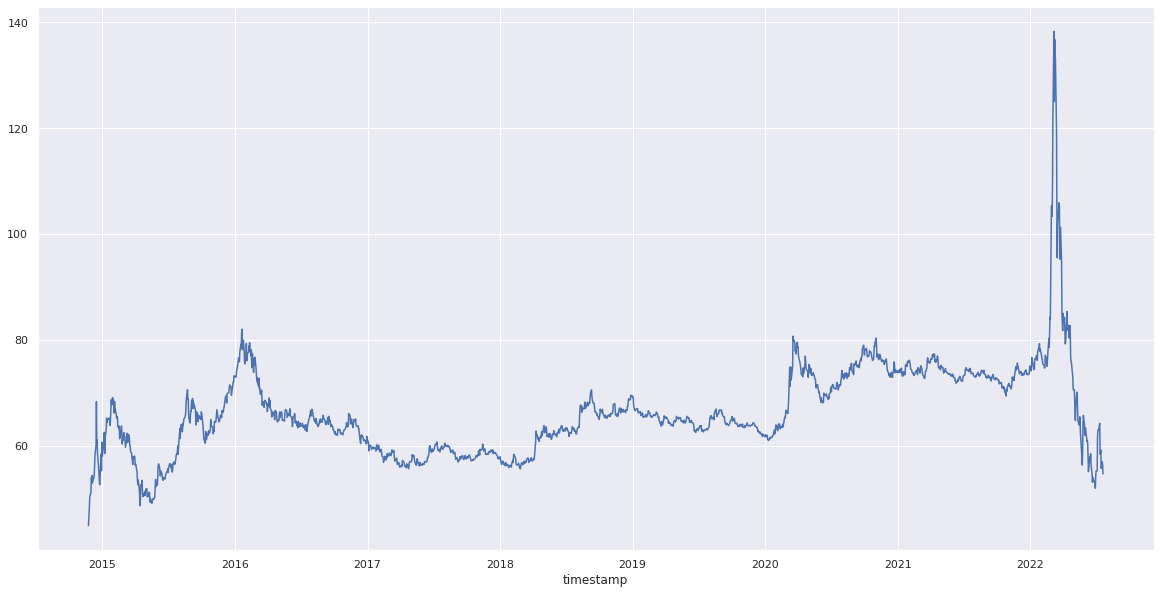

In [9]:
training_set = price_close
sns.set(rc={'figure.figsize':(20,10)})
g=sns.lineplot(y=pd.to_numeric(training_set.values), x=pd.to_datetime(training_set.index), data=training_set)


In [10]:
print(training_set)
print(len(training_set))

timestamp
2014-11-24    44.94000
2014-11-25    46.31390
2014-11-26    47.39360
2014-11-27    49.09690
2014-11-28    50.47380
                ...   
2022-07-14    59.20500
2022-07-15    55.75000
2022-07-18    56.99160
2022-07-19    56.49140
2022-07-20    54.70000
Name: close, Length: 1998, dtype: object
1998


## Dataloading

In [11]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_ = np.array(training_set[:1800]).reshape(-1, 1)
training_data = sc.fit_transform(training_)

seq_length = 30
x, y = sliding_windows(training_data, seq_length)

trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))

data_set = np.array(training_set[1800:]).reshape(-1, 1)
data_data = sc.transform(data_set)

seq_length = 30
a, b = sliding_windows(data_data, seq_length)

dataX = Variable(torch.Tensor(np.array(a)))
dataY = Variable(torch.Tensor(np.array(b)))


In [12]:
print(len(training_set[1800:]))
print(len(training_))


198
1800


## Model

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [14]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 10
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.17154
Epoch: 100, loss: 0.00077
Epoch: 200, loss: 0.00062
Epoch: 300, loss: 0.00053
Epoch: 400, loss: 0.00048
Epoch: 500, loss: 0.00046
Epoch: 600, loss: 0.00044
Epoch: 700, loss: 0.00043
Epoch: 800, loss: 0.00042
Epoch: 900, loss: 0.00041
Epoch: 1000, loss: 0.00040
Epoch: 1100, loss: 0.00040
Epoch: 1200, loss: 0.00039
Epoch: 1300, loss: 0.00039
Epoch: 1400, loss: 0.00039
Epoch: 1500, loss: 0.00039
Epoch: 1600, loss: 0.00038
Epoch: 1700, loss: 0.00038
Epoch: 1800, loss: 0.00038
Epoch: 1900, loss: 0.00038


## Testing 

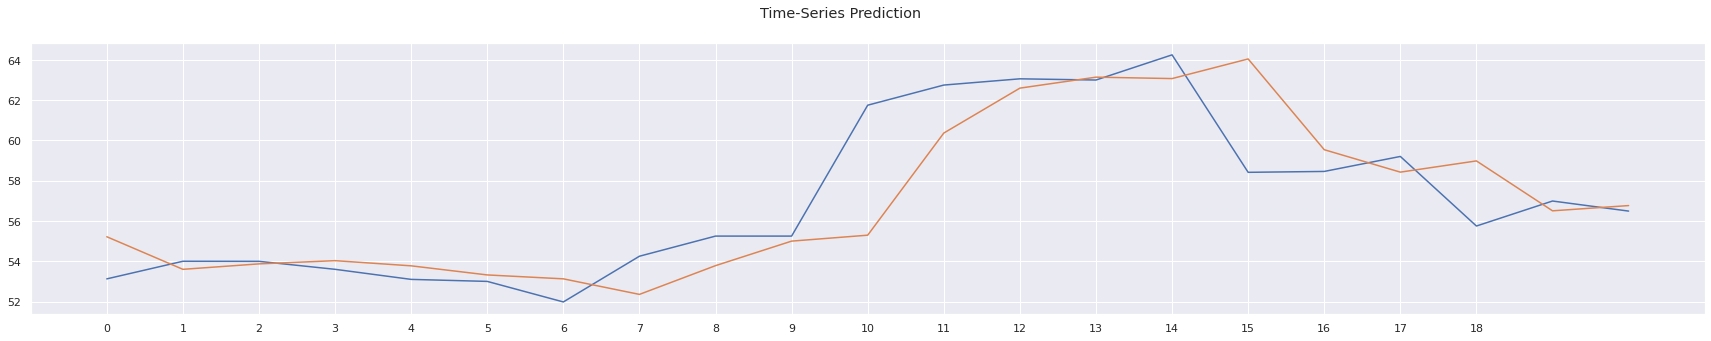

In [15]:
lstm.eval()
# train_predict = lstm(trainX)
train_predict_test = lstm(dataX)

# data_predict1 = train_predict.data.numpy()
data_predict1_test = train_predict_test.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict1)
data_predict_test = sc.inverse_transform(data_predict1_test[146:])
dataY_plot = sc.inverse_transform(dataY_plot[146:])

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(dataY_plot)
# plt.plot(data_predict)
plt.plot(data_predict_test)
plt.grid(True)
plt.xticks(range(0,19))
plt.suptitle('Time-Series Prediction')
plt.show()

In [16]:
with torch.no_grad():
  test_seq = dataX[:1]
  preds = []
  for _ in range(len(dataX)):
    y_test_pred = lstm(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [26]:
true_cases = sc.inverse_transform(np.expand_dims(dataY.flatten().numpy(), axis=0)).flatten()
true_cases


array([ 74.631004,  74.2292  ,  74.0339  ,  73.585205,  73.8208  ,
        74.046196,  73.853   ,  73.389   ,  73.6287  ,  73.285995,
        73.4521  ,  73.691   ,  73.4544  ,  73.848   ,  74.052   ,
        74.3321  ,  73.876   ,  73.6231  ,  73.4322  ,  73.6162  ,
        73.4424  ,  73.552   ,  73.64    ,  74.6868  ,  75.065   ,
        74.15    ,  74.591   ,  76.66881 ,  76.207   ,  75.805   ,
        74.865204,  74.3902  ,  74.4787  ,  76.365   ,  76.365105,
        76.69    ,  77.033   ,  76.175   ,  76.1408  ,  77.74    ,
        78.502   ,  78.499   ,  79.2752  ,  77.869   ,  78.285995,
        77.32    ,  76.8174  ,  76.40189 ,  76.37    ,  75.44    ,
        75.32001 ,  74.96999 ,  74.685905,  74.922   ,  77.116005,
        76.5046  ,  75.418   ,  75.018005,  76.3398  ,  77.366905,
        80.271   ,  78.59901 ,  81.137   ,  84.2925  ,  83.860794,
       105.290504, 105.      , 103.3505  , 109.146   , 121.787506,
       138.25    , 125.00001 , 136.75    , 132.75    , 133.25 

In [27]:
predicted_cases = sc.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
predicted_cases

array([75.39071034, 75.37173196, 75.3074733 , 75.24661784, 75.19438973,
       75.14796916, 75.1051551 , 75.06484261, 75.02643062, 74.98952575,
       74.9538319 , 74.91914575, 74.88533029, 74.85229712, 74.81997553,
       74.78833017, 74.75732566, 74.7269355 , 74.69713759, 74.66791424,
       74.6392522 , 74.61113379, 74.58354575, 74.5564704 , 74.5298989 ,
       74.50381799, 74.47820999, 74.45307049, 74.42838621, 74.40414834,
       74.38034802, 74.35697199, 74.33400921, 74.31145305, 74.28929245,
       74.26752079, 74.24612923, 74.22510451, 74.20444221, 74.1841379 ,
       74.16417834, 74.14455909, 74.12527133, 74.10630621, 74.08765931,
       74.06932621, 74.05129808, 74.03356606, 74.01613017, 73.99897715,
       73.98210698, 73.96551084, 73.94918431, 73.93311854, 73.91731354,
       73.90176488, 73.88646151, 73.87140123, 73.85657962, 73.84199447,
       73.82763914, 73.81350701, 73.79959807, 73.78590571, 73.77242549,
       73.759153  , 73.74608823, 73.73322236, 73.72055537, 73.70

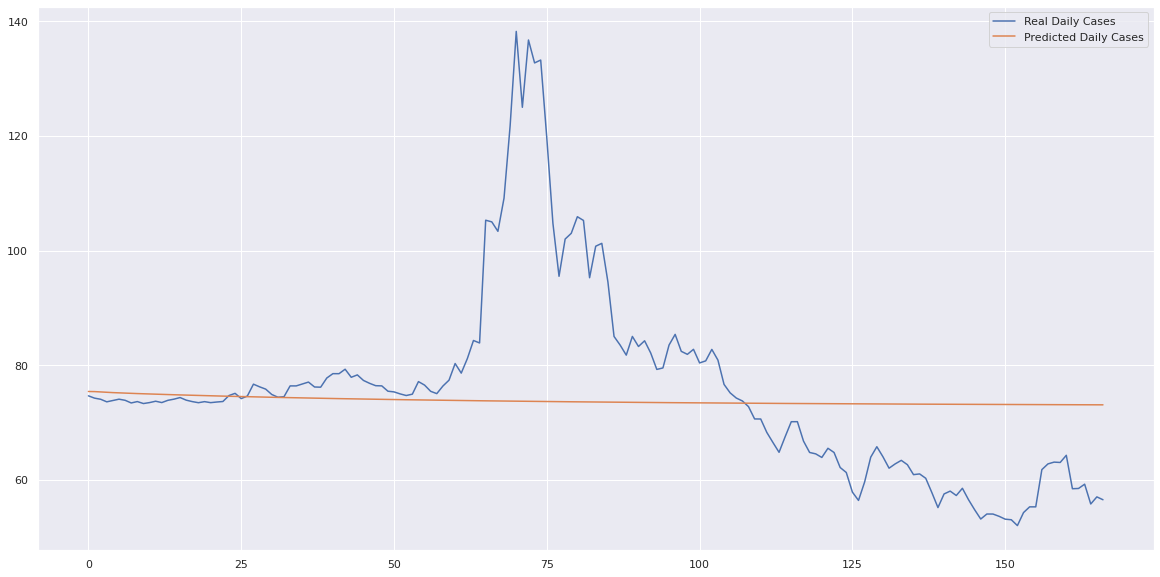

In [28]:

plt.plot(
  # daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases')

plt.plot(
  # daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases')

plt.legend()

In [ ]:

print(sc.inverse_transform(lstm(dataX[:1]).data.numpy()))
print(sc.inverse_transform(dataY[:1].data.numpy()))
print((dataX[:1]))
print(len(dataX))

In [54]:
q1 = dataX[161:162].data.numpy()
q1 = np.append(q1, lstm(dataX[161:162]).data.numpy())
q1 = np.delete(q1, 0).reshape(-1, 1)
tensor_q1 = torch.Tensor([q1])
print(tensor_q1)
print(lstm(tensor_q1))
print(sc.inverse_transform(lstm(tensor_q1).data.numpy()))
print(sc.inverse_transform(dataY[162:163].data.numpy()))



tensor([[[0.4804],
         [0.4970],
         [0.4766],
         [0.4298],
         [0.4332],
         [0.4127],
         [0.3455],
         [0.2747],
         [0.3389],
         [0.3523],
         [0.3315],
         [0.3655],
         [0.3118],
         [0.2646],
         [0.2208],
         [0.2444],
         [0.2443],
         [0.2336],
         [0.2201],
         [0.2174],
         [0.1899],
         [0.2511],
         [0.2781],
         [0.2781],
         [0.4534],
         [0.4804],
         [0.4887],
         [0.4871],
         [0.5208],
         [0.5286]]])
tensor([[0.5391]], grad_fn=<AddmmBackward0>)
[[64.92734]]
[[58.460598]]


In [55]:
q2 = tensor_q1.data.numpy()
q2 = np.append(q2, lstm(tensor_q1).data.numpy())
q2 = np.delete(q2, 0).reshape(-1, 1)
tensor_q2 = torch.Tensor([q2])
print(tensor_q2)
print(lstm(tensor_q2))
print(sc.inverse_transform(lstm(tensor_q2).data.numpy()))
print(sc.inverse_transform(dataY[163:164].data.numpy()))



tensor([[[0.4970],
         [0.4766],
         [0.4298],
         [0.4332],
         [0.4127],
         [0.3455],
         [0.2747],
         [0.3389],
         [0.3523],
         [0.3315],
         [0.3655],
         [0.3118],
         [0.2646],
         [0.2208],
         [0.2444],
         [0.2443],
         [0.2336],
         [0.2201],
         [0.2174],
         [0.1899],
         [0.2511],
         [0.2781],
         [0.2781],
         [0.4534],
         [0.4804],
         [0.4887],
         [0.4871],
         [0.5208],
         [0.5286],
         [0.5391]]])
tensor([[0.5480]], grad_fn=<AddmmBackward0>)
[[65.258385]]
[[59.204998]]


In [56]:
q3 = tensor_q2.data.numpy()
q3 = np.append(q3, lstm(tensor_q2).data.numpy())
q3 = np.delete(q3, 0).reshape(-1, 1)
tensor_q3 = torch.Tensor([q3])
print(tensor_q3)
print(lstm(tensor_q3))
print(sc.inverse_transform(lstm(tensor_q3).data.numpy()))
print(sc.inverse_transform(dataY[164:165].data.numpy()))

tensor([[[0.4766],
         [0.4298],
         [0.4332],
         [0.4127],
         [0.3455],
         [0.2747],
         [0.3389],
         [0.3523],
         [0.3315],
         [0.3655],
         [0.3118],
         [0.2646],
         [0.2208],
         [0.2444],
         [0.2443],
         [0.2336],
         [0.2201],
         [0.2174],
         [0.1899],
         [0.2511],
         [0.2781],
         [0.2781],
         [0.4534],
         [0.4804],
         [0.4887],
         [0.4871],
         [0.5208],
         [0.5286],
         [0.5391],
         [0.5480]]])
tensor([[0.5557]], grad_fn=<AddmmBackward0>)
[[65.54435]]
[[55.75]]


In [57]:
q4 = tensor_q3.data.numpy()
q4 = np.append(q4, lstm(tensor_q3).data.numpy())
q4 = np.delete(q4, 0).reshape(-1, 1)
tensor_q4 = torch.Tensor([q4])
print(tensor_q4)
print(lstm(tensor_q4))
print(sc.inverse_transform(lstm(tensor_q4).data.numpy())[0][0])
print(sc.inverse_transform(dataY[165:166].data.numpy()))

tensor([[[0.4298],
         [0.4332],
         [0.4127],
         [0.3455],
         [0.2747],
         [0.3389],
         [0.3523],
         [0.3315],
         [0.3655],
         [0.3118],
         [0.2646],
         [0.2208],
         [0.2444],
         [0.2443],
         [0.2336],
         [0.2201],
         [0.2174],
         [0.1899],
         [0.2511],
         [0.2781],
         [0.2781],
         [0.4534],
         [0.4804],
         [0.4887],
         [0.4871],
         [0.5208],
         [0.5286],
         [0.5391],
         [0.5480],
         [0.5557]]])
tensor([[0.5621]], grad_fn=<AddmmBackward0>)
65.78086
[[56.9916]]


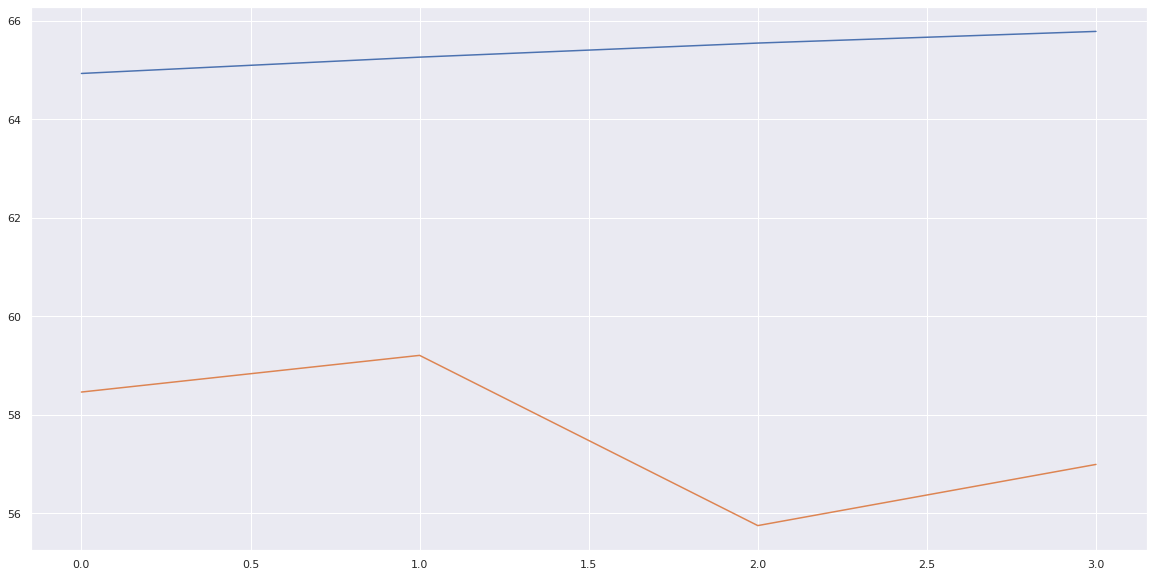

In [58]:
plt.plot([
          sc.inverse_transform(lstm(tensor_q1).data.numpy())[0],
          sc.inverse_transform(lstm(tensor_q2).data.numpy())[0],
          sc.inverse_transform(lstm(tensor_q3).data.numpy())[0],
          sc.inverse_transform(lstm(tensor_q4).data.numpy())[0],

          ])
plt.plot(sc.inverse_transform(dataY[162:166].data.numpy()))

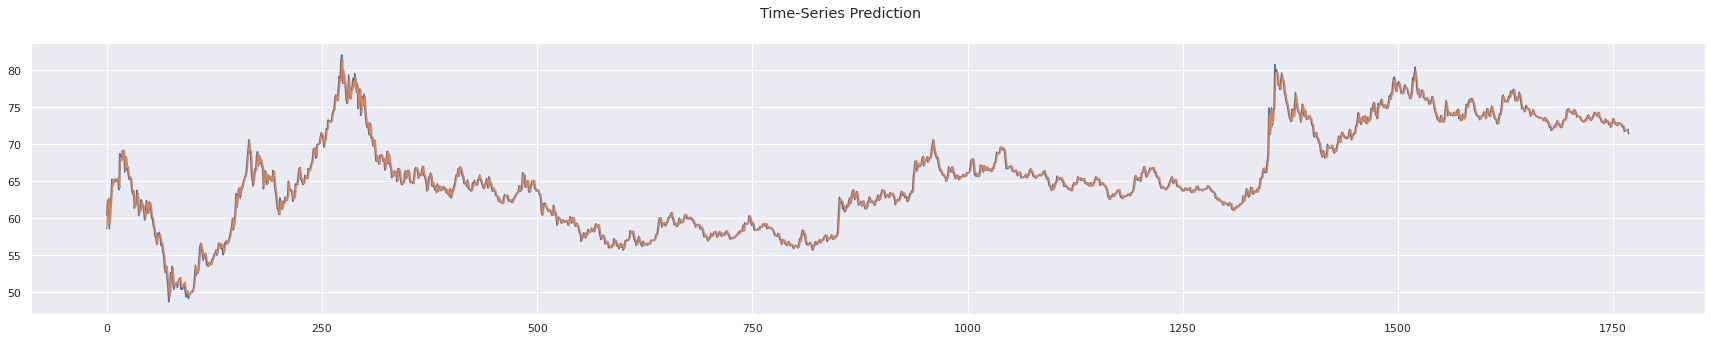

In [53]:
lstm.eval()
train_predict = lstm(trainX)
# train_predict_test = lstm(dataX)

data_predict1 = train_predict.data.numpy()
# data_predict1_test = train_predict_test.data.numpy()
trainY_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict1)
# data_predict_test = sc.inverse_transform(data_predict1_test)
trainY_plot = sc.inverse_transform(trainY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')
plt.figure(figsize=(30, 5))
plt.plot(trainY_plot)
# plt.plot(data_predict)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()


